# Prosup  Classifier

In [43]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Data Analysis Section

<AxesSubplot:title={'center':'Subjects/Deepti/computed_Bulb02.csv'}>

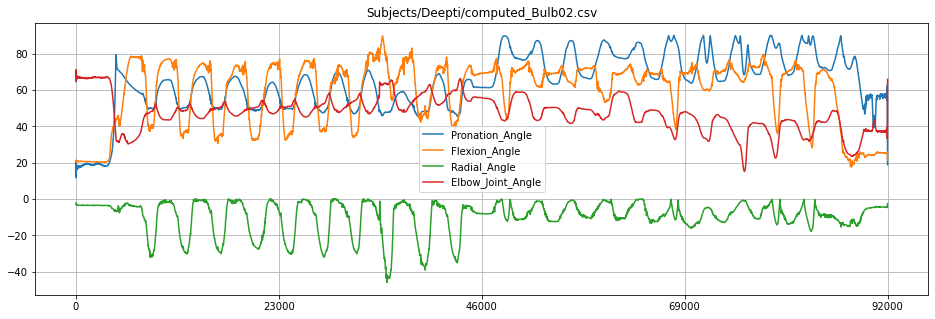

In [45]:
file = 'Subjects/Deepti/computed_Bulb02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle']
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

In [46]:
b,a = signal.butter(1, 50,fs=2000)
emg_df = pd.DataFrame(columns=emg_labels)
for labels in emg_labels:
    emg_df[labels] = signal.lfilter(b, a,df[labels])
df[emg_labels] = np.array(emg_df)

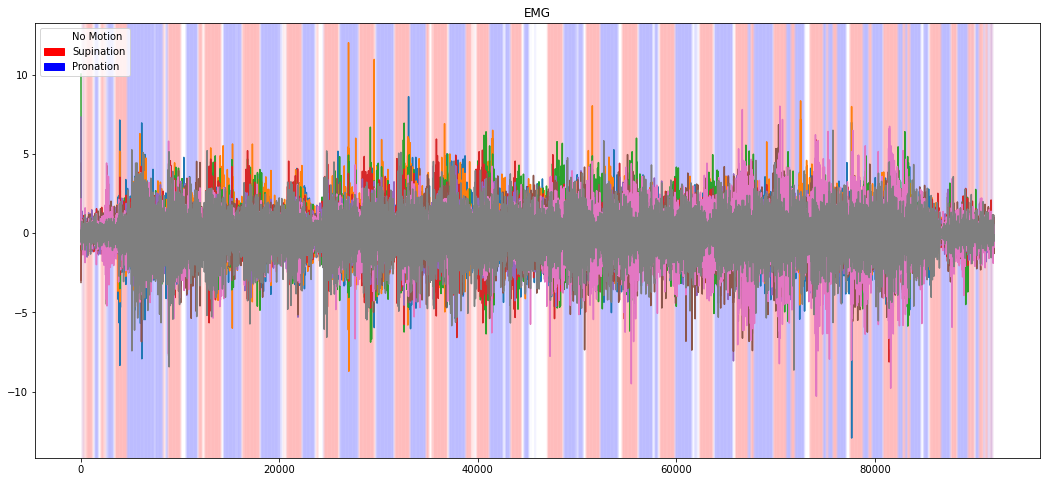

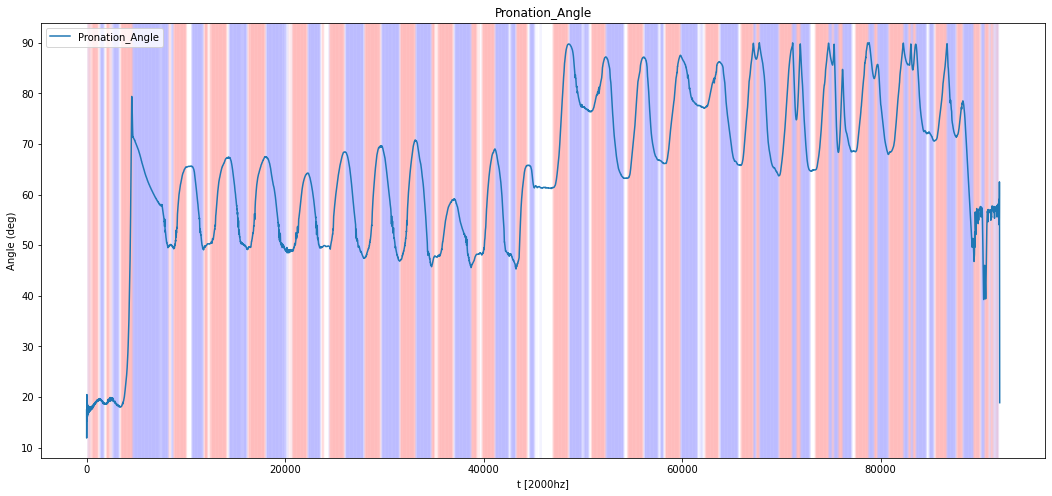

0 -> 12.88213176393657 %
1 -> 41.507274807912374 %
2 -> 45.610593428151056 %


(6117, 250, 8)

In [47]:
X, y = prep_data_prosup(df,250,interval=15,Normalize=False,plot=True,angle_thresh=0.001,rms=False)
X.shape

## File Name Generation

In [76]:
files = []
subjects = ['Fazil','Nikhil','Ingy','Abhishek','Varun','Jai'] #'Fazil/day_04_14_21'

In [77]:
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Bulb'] # 'Bulb','Hammer' ,'Cup','Screw'
#     trial_names = ['Bulb','Hammer' ,'Cup','Screw']
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/computed_Bulb.csv',
 'Subjects/Fazil/computed_Bulb01.csv',
 'Subjects/Fazil/computed_Bulb02.csv',
 'Subjects/Nikhil/computed_Bulb.csv',
 'Subjects/Nikhil/computed_Bulb01.csv',
 'Subjects/Nikhil/computed_Bulb02.csv',
 'Subjects/Ingy/computed_Bulb.csv',
 'Subjects/Ingy/computed_Bulb01.csv',
 'Subjects/Ingy/computed_Bulb02.csv',
 'Subjects/Abhishek/computed_Bulb.csv',
 'Subjects/Abhishek/computed_Bulb01.csv',
 'Subjects/Abhishek/computed_Bulb02.csv',
 'Subjects/Varun/computed_Bulb.csv',
 'Subjects/Varun/computed_Bulb01.csv',
 'Subjects/Varun/computed_Bulb02.csv',
 'Subjects/Jai/computed_Bulb.csv',
 'Subjects/Jai/computed_Bulb01.csv',
 'Subjects/Jai/computed_Bulb02.csv']

In [78]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [79]:
def filter_df(files_df,order=1,cf=50,fs=2000):
    b,a = signal.butter(order, cf,fs=fs)
    for i in range(len(files_df)):
        emg_df = pd.DataFrame(columns=emg_labels)
        for labels in emg_labels:
            emg_df[labels] = signal.lfilter(b, a,files_df[i][labels])
        files_df[i][emg_labels] = np.array(emg_df)
    return files_df

In [80]:
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']

In [81]:
files_df = filter_df(files_df)

## Data Augumentation

### Gausian Noise

In [11]:
files_df_gausian = []
for df in tqdm(files_df):
    snr = choice(np.linspace(60,90,5))
    emg_array = np.array(add__Gausian_noise(df[emg_labels],snr))
    df[emg_labels] = emg_array
    files_df_gausian.append(df)

files_df = files_df+files_df_gausian
len(files_df)

44

### Rearrange 

In [82]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [83]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

54

## Data Prep Pipeline

### Parameters

In [84]:
window = 250
interval = 25
Normalize = False
rms = False
angle_thresh = 0.001

In [85]:
X_prosup, y_prosup = multiple_prep_data_prosup(files_df,
                                      window,
                                      interval,
                                      Normalize,
                                      rms,
                                      angle_thresh)
print(X_prosup.shape,y_prosup.shape)


(198180, 250, 8) (198180, 3)


In [35]:
np.save('X_test_prosup',X_prosup)
np.save('y_test_prosup',y_prosup)

## Whole Normalize

In [23]:
def norm2(X):
    X2 = X.reshape((X.shape[0]*window,X.shape[2]))
    column_max = []
    for i in tqdm(range(X2.shape[1])):
        scaler = StandardScaler()
        X2[:,i] = scaler.fit_transform(X2[:,i].reshape(-1,1)).reshape((len(X2)))
#         X2[:,i] = (X2[:,i] - X2[:,i].max())/variance(X2[:,i]) 
    return X2.reshape(X.shape)
X_prosup = norm2(X_prosup)

In [54]:
def norm2(X):
    X2 = X.reshape((X.shape[0]*window,X.shape[2]))
    scaler_mx = MinMaxScaler((0,1))
    scaler_std = StandardScaler()
#     X2 = scaler_std.fit_transform(X2)
    X2 = scaler_mx.fit_transform(X2)
    return X2.reshape(X.shape)
X_prosup = norm2(X_prosup)

### TW Normalize

‘‘time window normalization’’ (i.e., subtracting to
each time window the mean and dividing it by the standard
deviation) and ‘‘normalization based on training data’’ (i.e.,
subtracting to all the time windows the training data mean and
dividing them by the training data standard deviation).

In [86]:
def variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [87]:
X_mean = np.zeros(X_prosup[0].shape)
for x in X_prosup:
    X_mean = X_mean + x
X_mean = X_mean/X_prosup.shape[0]
X_std = np.sqrt(variance(X_prosup))
np.save('mean_std',np.array([X_mean,X_std]))

In [88]:
X = []
for x in tqdm(X_prosup):
    X.append((x-X_mean)/X_std)
X_prosup = np.array(X)

In [130]:
np.save('prepared_data/X_prosup_rearr_tw',X_prosup)
np.save('prepared_data/y_prosup_rearr_tw',y_prosup)

In [2]:
X_prosup = np.load('prepared_data/X_prosup_rearr_tw.npy')
y_prosup = np.load('prepared_data/y_prosup_rearr_tw.npy')

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X_prosup, y_prosup,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(158544, 250, 8)
(39636, 250, 8)
(158544, 3)
(39636, 3)


In [90]:
y_true = []
for d in y_test:
    idx = list(d).index(1)
    y_true.append(idx)

In [91]:
def count(y):
    s0 = 0
    s1 = 0
    s2 = 0
    for arr in y:
        if arr[0]==1:
            s0 = s0+1
        if arr[1]==1:
            s1 = s1+1
        if arr[2]==1:
            s2 = s2+1
    ls = [s0,s1,s2]
    for i in range(3):
        print(i,'-',ls[i],'[',ls[i]*100/len(y),'%]')

In [92]:
print(count(y_train))
print(count(y_test))

0 - 48491 [ 30.585200322938743 %]
1 - 56080 [ 35.371884145726106 %]
2 - 53973 [ 34.04291553133515 %]
None
0 - 12058 [ 30.421838732465435 %]
1 - 14261 [ 35.97991724694722 %]
2 - 13317 [ 33.598244020587344 %]
None


# InceptionTime Trainer

In [93]:
import numpy as np
import sklearn
import pandas as pd
import sys
import subprocess
import tensorflow as tf
from InceptionTime.classifiers.inception import Classifier_INCEPTION

In [94]:
clf = Classifier_INCEPTION('', (X_train.shape[1],X_train.shape[2]),nb_classes=3,
                            verbose=True,batch_size=256,nb_epochs=100,nb_filters=32,
                            depth=16, kernel_size=11)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 250, 8)]     0                                            
__________________________________________________________________________________________________
conv1d_425 (Conv1D)             (None, 250, 32)      256         input_6[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_80 (MaxPooling1D) (None, 250, 8)       0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_426 (Conv1D)             (None, 250, 32)      10240       conv1d_425[0][0]                 
____________________________________________________________________________________________

In [95]:
df_metrics = clf.fit(X_train, y_train, X_test, y_test, y_true,plot_test_acc=True)

Epoch 1/100
620/620 [==============================] - 223s 344ms/step - loss: 0.9379 - accuracy: 0.5450 - val_loss: 1.0119 - val_accuracy: 0.5591
Epoch 2/100
620/620 [==============================] - 234s 377ms/step - loss: 0.6745 - accuracy: 0.7076 - val_loss: 0.6225 - val_accuracy: 0.7326
Epoch 3/100
620/620 [==============================] - 238s 385ms/step - loss: 0.4762 - accuracy: 0.8093 - val_loss: 0.5360 - val_accuracy: 0.7910
Epoch 4/100
620/620 [==============================] - 238s 384ms/step - loss: 0.3715 - accuracy: 0.8581 - val_loss: 0.4061 - val_accuracy: 0.8471
Epoch 5/100
620/620 [==============================] - 238s 384ms/step - loss: 0.3162 - accuracy: 0.8814 - val_loss: 0.5158 - val_accuracy: 0.8119
Epoch 6/100
620/620 [==============================] - 236s 380ms/step - loss: 0.2816 - accuracy: 0.8953 - val_loss: 0.3446 - val_accuracy: 0.8727
Epoch 7/100
620/620 [==============================] - 235s 379ms/step - loss: 0.2608 - accuracy: 0.9028 - val_loss: 0

In [ ]:
clf.model = load_model('best_model.hdf5')

In [96]:
best_model = load_model('best_model.hdf5')
best_model.save('models/prosup_{}_tw_98.hdf5'.format(window))

c:\users\moham\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [97]:
system_sleep()

## Testing

In [25]:
model = load_model('best_model.hdf5')

In [33]:
# mx_scaler = load(open('min_max.pkl', 'rb'))
# std_scaler = load(open('standard_scaler.pkl', 'rb'))

# X = mx_scaler.transform(X)
# X = std_scaler.transform(X)
X = X_dtm.reshape(X_dtm.shape[0]*X_dtm.shape[1],X_dtm.shape[2])
scale_param = np.load('scale_param.npy')
print(scale_param)
X = map_it(X,scale_param[0],scale_param[1])
X_dtm = X.reshape(X_dtm.shape)

[[-2.50412559  1.50388032]
 [-1.          1.        ]]


In [34]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]

In [35]:
X = []
for x in tqdm(X_dtm):
    X.append((x-X_mean)/X_std)
X_dtm = np.array(X)

In [36]:
model.evaluate(X_dtm,y_dtm)

4745/4745 [==============================] - 51s 11ms/step - loss: 35298.5703 - accuracy: 0.3006


[35298.5703125, 0.3005908131599426]

## Plot Results

In [98]:
%matplotlib inline
metrics_df = pd.read_csv('df_metrics.csv')
best_model_df = pd.read_csv('df_best_model.csv')
history_df = pd.read_csv('history.csv')

In [99]:
metrics_df

,precision,accuracy,recall,duration
0,0.98788,0.988117,0.987823,23459.911382


<AxesSubplot:title={'center':'Loss'}>

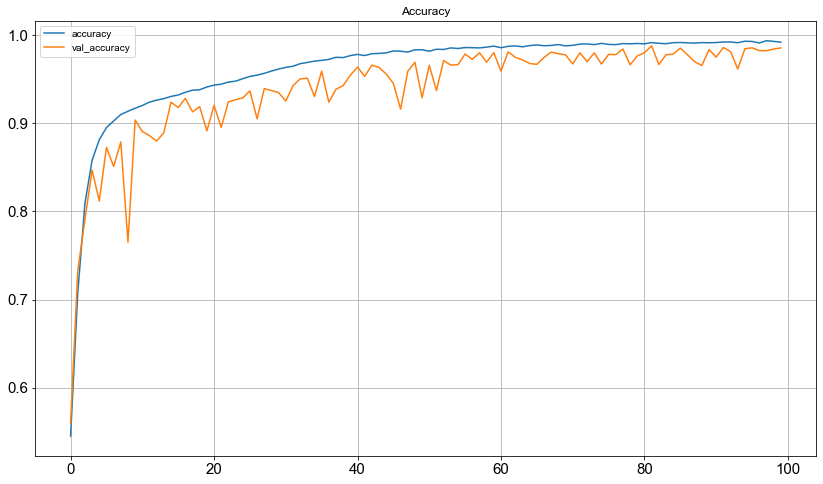

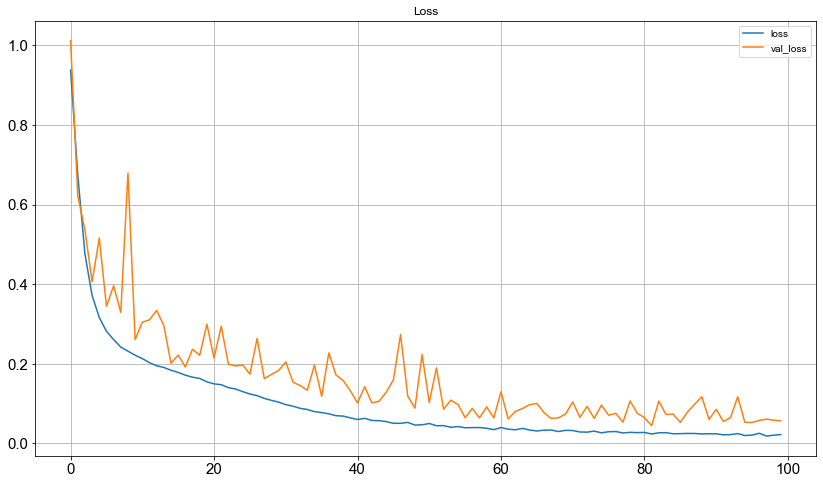

In [100]:
history_df[['accuracy','val_accuracy']].plot(figsize=(14,8),title='Accuracy',grid=True,fontsize=15)
history_df[['loss','val_loss']].plot(figsize=(14,8),title='Loss',grid=True,fontsize=15)

In [ ]:
system_sleep()